In [1]:
import os

import pandas as pd
from pandas.api.types import is_string_dtype

import numpy as np

import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt

In [2]:
def tratar_dataset(dataset):
    
    for coluna in dataset.columns:
        if is_string_dtype(dataset[coluna]):
            dataset[coluna] = dataset[coluna].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
            dataset[coluna] = dataset[coluna].str.upper()
            
    dataset.columns = map(str.upper, dataset.columns)
    
    return dataset


def localizar_modelo(dataset, lista_estados, dicionario):
    for estado in lista_estados:
        df_modelo_uf = dataset.query('UF == @estado')[["LEADS", "COD_MODELO_VEICULO"]].groupby(by=["COD_MODELO_VEICULO"]).sum().sort_values(by="LEADS", ascending=False).head()
        
        dicionario["UF"].append(estado)

        for indice, (modelo, lead) in enumerate(df_modelo_uf.iterrows()):
            dicionario[f"TOP {indice + 1}"].append([modelo, lead.LEADS])

    return pd.DataFrame(dicionario)
    

def localizar_marca(dataset, lista_estados, dicionario):
    for estado in lista_estados:
        df_marca_uf = dataset.query('UF == @estado')[["LEADS", "COD_MARCA_VEICULO"]].groupby(by=["COD_MARCA_VEICULO"]).sum().sort_values(by="LEADS", ascending=False).head()
        
        dicionario["UF"].append(estado)

        for indice, (marca, lead) in enumerate(df_marca_uf.iterrows()):
            dicionario[f"TOP {indice + 1}"].append([marca, lead.LEADS])

    return pd.DataFrame(dicionario)

In [3]:
pd.options.display.max_columns = None


In [4]:
dataset = pd.read_csv("../datasets/Case 1 - dados.csv", sep=",")


In [63]:
len(dataset)

48661

In [66]:
len(dataset.drop_duplicates())

48661

In [5]:
tratar_dataset(dataset)

,COD_ANUNCIO,COD_CLIENTE,COD_TIPO_PESSOA,PRIORIDADE,LEADS,VIEWS,CLIQUES_TELEFONE*,COD_MARCA_VEICULO,COD_MODELO_VEICULO,COD_VERSAO_VEICULO,ANO_MODELO,CEP_2DIG,UF_CIDADE,VLR_ANUNCIO,QTD_FOTOS,KM_VEICULO,VLR_MERCADO,FLG_UNICO_DONO,FLG_LICENCIADO,FLG_IPVA_PAGO,FLG_TODAS_REVISOES_CONCESSIONARIA,FLG_TODAS_REVISOES_AGENDA_VEICULO,FLG_GARANTIA_FABRICA,FLG_BLINDADO,FLG_ACEITA_TROCA,FLG_ADAPTADO_PCD,COMBUSTIVEL,CAMBIO,PORTAS,ALARME,AIRBAG,ARQUENTE,BANCOCOURO,ARCONDIC,ABS,DESEMBTRAS,TRAVAELETR,VIDROSELETR,RODASLIGA,SENSORCHUVA,SENSORESTACION
0,2,7941,2,3,1,0,0,34,769,346932,2018,75,GO_ITUMBIARA,110990.00,7,0,NaN,0,0,0.0,0.0,0,0.0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,1770,1,3,1,0,4,2,704,340148,1996,6,SP_OSASCO,8300.00,0,689815,NaN,0,0,0.0,0.0,0,0.0,0,0,0.0,ALCOOL,MANUAL,2.0,S,NaN,S,N,N,S,N,S,S,N,N,N
2,8,709,1,3,4,0,11,30,1071,310713,2002,2,SP_SAO PAULO,38800.00,4,33700,NaN,0,0,0.0,0.0,0,0.0,0,0,0.0,GASOLINA,MANUAL,4.0,S,NaN,S,N,S,S,S,S,S,S,N,N
3,13,9708,1,2,12,0,14,10,2028,341195,1995,4,SP_SAO PAULO,44000.00,8,105000,NaN,0,1,1.0,0.0,0,0.0,0,0,0.0,GASOLINA,AUTOMATICO,2.0,N,S,S,S,S,N,N,S,S,S,N,N
4,15,1363,1,2,8,0,11,12,805,332063,1995,5,SP_SAO PAULO,30000.00,6,71240,NaN,0,0,0.0,0.0,0,0.0,0,0,0.0,GASOLINA,AUTOMATICO,4.0,S,N,S,S,S,S,S,S,S,S,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48660,195918,3065,2,3,1,34184,0,280,3365,346359,2016,17,SP_JAAO,48000.00,8,35000,48011.33387,0,0,NaN,NaN,0,NaN,0,0,NaN,GASOLINA,MANUAL,4.0,S,S,S,S,S,S,S,S,S,S,N,S
48661,195924,12535,2,3,1,45048,0,4,1177,343882,2013,25,RJ_DUQUE DE CAXIAS,42999.99,1,91222,43085.32550,0,0,NaN,NaN,0,NaN,0,0,NaN,GASOLINA E ALCOOL,MANUAL,4.0,N,N,N,N,N,N,N,N,N,N,N,N
48662,195930,2284,2,3,1,71020,0,5,3128,344252,2012,13,SP_JUNDIAA,93900.00,0,120000,81696.56707,0,0,NaN,NaN,0,NaN,0,0,NaN,DIESEL,AUTOMATICO,4.0,N,N,N,N,N,N,N,N,N,N,N,N
48663,195934,2284,2,3,0,82940,0,2,3323,344421,2014,13,SP_JUNDIAA,53800.00,0,40000,45804.01330,0,0,NaN,NaN,0,NaN,0,0,NaN,GASOLINA E ALCOOL,AUTOMATICO,4.0,S,N,S,N,S,N,S,S,S,S,N,N


In [7]:
dataset.isna().sum()

COD_ANUNCIO                             0
COD_CLIENTE                             0
COD_TIPO_PESSOA                         0
PRIORIDADE                              0
LEADS                                   0
VIEWS                                   0
CLIQUES_TELEFONE*                       0
COD_MARCA_VEICULO                       0
COD_MODELO_VEICULO                      0
COD_VERSAO_VEICULO                      0
ANO_MODELO                              0
CEP_2DIG                                0
UF_CIDADE                               0
VLR_ANUNCIO                             0
QTD_FOTOS                               0
KM_VEICULO                              0
VLR_MERCADO                          6217
FLG_UNICO_DONO                          0
FLG_LICENCIADO                          0
FLG_IPVA_PAGO                         312
FLG_TODAS_REVISOES_CONCESSIONARIA     312
FLG_TODAS_REVISOES_AGENDA_VEICULO       0
FLG_GARANTIA_FABRICA                  312
FLG_BLINDADO                      

In [6]:
dataset.fillna(dataset.median(), inplace=True)


C:\Users\Mayara Lopes\AppData\Local\Temp\ipykernel_11616\2957278261.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset.fillna(dataset.median(), inplace=True)


In [7]:
dataset[["UF", "CIDADE"]] = dataset["UF_CIDADE"].str.split("_", expand=True)

In [31]:
dataset["UF"].value_counts()

SP     22918
PR      4440
SC      3760
RJ      3717
MG      3243
RS      2609
DF      1758
GO       931
PE       771
BA       632
MS       553
RN       530
CE       524
ES       472
MT       409
PB       236
MA       232
PA       181
RO       164
AM       158
PI       146
SE       119
AL        80
AC        32
AP        18
RR        15
TO        13
N/A        4
Name: UF, dtype: int64

In [8]:
dataset = dataset[dataset["UF"] != "N/A"]


In [9]:
dataset_modelo = dataset[["LEADS", "COD_MODELO_VEICULO"]].groupby(by=["COD_MODELO_VEICULO"]).sum()

In [70]:
dataset_modelo.value_counts()

LEADS
1        62
0        39
4        35
12       24
8        18
         ..
299       1
309       1
312       1
320       1
7982      1
Length: 293, dtype: int64

In [10]:
dataset_marca = dataset[["LEADS", "COD_MARCA_VEICULO"]].groupby(by=["COD_MARCA_VEICULO"]).sum()

In [72]:
dataset_marca.value_counts()

LEADS
4        8
1        7
0        3
6563     2
20       2
28       2
18537    1
15912    1
26911    1
821      1
839      1
1089     1
1138     1
1257     1
1389     1
1642     1
3261     1
3556     1
4616     1
4804     1
4966     1
511      1
5343     1
5689     1
20706    1
19798    1
6574     1
9913     1
12260    1
659      1
304      1
478      1
341      1
5        1
6        1
7        1
8        1
9        1
10       1
17       1
18       1
19       1
21       1
24       1
30       1
40       1
42       1
44       1
46       1
53       1
66       1
69       1
97       1
115      1
186      1
210      1
27213    1
dtype: int64

In [11]:
dataset_marca.sort_values(by="LEADS", ascending=False).head()

,LEADS
COD_MARCA_VEICULO,
5,27213
2,26911
16,20706
4,19798
3,18537


c:\Users\Mayara Lopes\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

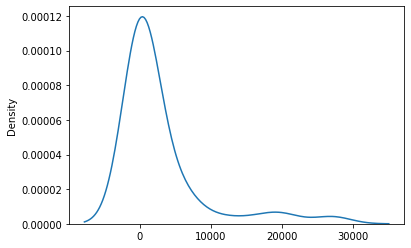

In [89]:
sns.distplot(x=dataset_marca["LEADS"], hist=False)

In [12]:
dataset_modelo.sort_values(by="LEADS", ascending=False).head()

,LEADS
COD_MODELO_VEICULO,
690,7982
1194,5927
776,5410
740,4533
687,4509


c:\Users\Mayara Lopes\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

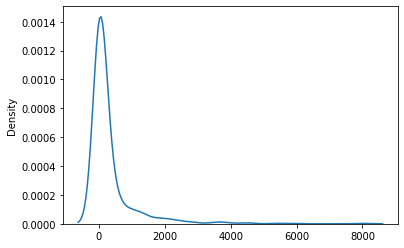

In [90]:
sns.distplot(x=dataset_modelo["LEADS"], hist=False)

In [12]:
dataset_uf = dataset[["LEADS", "UF"]].groupby(by=["UF"]).sum()

In [14]:
dataset_uf.sort_values(by="LEADS", ascending=False).head()

,LEADS
UF,
SP,151382
RJ,15177
MG,9973
PR,9638
SC,6609


In [14]:
dataset_cidade = dataset[["LEADS", "CIDADE"]].groupby(by=["CIDADE"]).sum()

In [17]:
dataset_cidade.sort_values(by="LEADS", ascending=False).head()

,LEADS
CIDADE,
SAO PAULO,88765
RIO DE JANEIRO,11020
CAMPINAS,7407
BELO HORIZONTE,5721
SAO BERNARDO DO CAMPO,5248


In [16]:
df_modelo = {"UF": [],
    "TOP 1": [],
    "TOP 2": [],
    "TOP 3": [],
    "TOP 4": [],
    "TOP 5": [],
    }

df_marca = {"UF": [],
    "TOP 1": [],
    "TOP 2": [],
    "TOP 3": [],
    "TOP 4": [],
    "TOP 5": [],
    }

lista_estados = ["SP", "RJ", "MG", "PR", "SC"]

df_modelo = localizar_modelo(dataset, lista_estados, df_modelo)
df_marca = localizar_marca(dataset, lista_estados, df_marca)

In [70]:
df_marca

,UF,TOP 1,TOP 2,TOP 3,TOP 4,TOP 5
0,SP,"[2, 19208]","[5, 19130]","[16, 16102]","[3, 13592]","[17, 12302]"
1,RJ,"[4, 1893]","[16, 1718]","[5, 1520]","[2, 1213]","[3, 1107]"
2,MG,"[4, 1400]","[5, 1371]","[2, 1039]","[3, 700]","[16, 553]"
3,PR,"[2, 1552]","[5, 1304]","[4, 1085]","[16, 887]","[3, 592]"
4,SC,"[5, 1011]","[2, 992]","[4, 721]","[3, 580]","[30, 401]"


In [23]:
df_modelo

,UF,TOP 1,TOP 2,TOP 3,TOP 4,TOP 5
0,SP,"[690, 5892]","[1194, 5019]","[776, 4077]","[687, 3473]","[1222, 2834]"
1,RJ,"[690, 656]","[740, 617]","[2848, 450]","[1194, 367]","[1193, 327]"
2,MG,"[740, 380]","[1057, 271]","[761, 261]","[690, 237]","[788, 232]"
3,PR,"[690, 551]","[761, 418]","[776, 258]","[788, 256]","[740, 170]"
4,SC,"[788, 209]","[690, 202]","[740, 166]","[763, 164]","[687, 162]"


In [32]:
dataset.query('UF == "SP"')[["LEADS", "COD_MODELO_VEICULO"]].groupby(by=["COD_MODELO_VEICULO"]).sum().sort_values(by="LEADS", ascending=False).head()

,LEADS
COD_MODELO_VEICULO,
690,5892
1194,5019
776,4077
687,3473
1222,2834


In [104]:
dataset.query('UF == "SP"')[["LEADS", "COD_MARCA_VEICULO"]].groupby(by=["COD_MARCA_VEICULO"]).sum().sort_values(by="LEADS", ascending=False).head()

,LEADS
COD_MARCA_VEICULO,
2,19208
5,19130
16,16102
3,13592
17,12302


In [43]:
dataset[["LEADS", "COD_MODELO_VEICULO", "COD_MARCA_VEICULO", "UF"]]

,LEADS,COD_MODELO_VEICULO,COD_MARCA_VEICULO,UF
0,1,769,34,GO
1,1,704,2,SP
2,4,1071,30,SP
3,12,2028,10,SP
4,8,805,12,SP
...,...,...,...,...
48660,1,3365,280,SP
48661,1,1177,4,RJ
48662,1,3128,5,SP
48663,0,3323,2,SP


In [42]:
dataset.LEADS.value_counts()

1      23394
0      10629
4       6507
8       2870
12      1586
       ...  
252        1
160        1
172        1
156        1
140        1
Name: LEADS, Length: 64, dtype: int64

In [17]:
dataset["APRESENTA_LEAD"] = np.where(dataset["LEADS"] > 0, 1, 0)

C:\Users\Mayara Lopes\AppData\Local\Temp\ipykernel_11616\3360614176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["APRESENTA_LEAD"] = np.where(dataset["LEADS"] > 0, 1, 0)


In [18]:
encoder = LabelEncoder()

dataset["UF"] = encoder.fit_transform(dataset["UF"])

C:\Users\Mayara Lopes\AppData\Local\Temp\ipykernel_11616\2955351914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["UF"] = encoder.fit_transform(dataset["UF"])


In [19]:
X = dataset[["UF", "COD_MODELO_VEICULO", "COD_MARCA_VEICULO"]]
y = dataset["APRESENTA_LEAD"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [21]:
random_forest = RandomForestClassifier(max_depth=2, random_state=1)
random_forest.fit(X_train, y_train)
predicao = random_forest.predict(X_test)

In [22]:
recall = recall_score(y_test, predicao)
precisao = precision_score(y_test, predicao)
f1 = f1_score(y_test, predicao)
acuracia = accuracy_score(y_test, predicao)


In [110]:
dataset.columns

Index(['COD_ANUNCIO', 'COD_CLIENTE', 'COD_TIPO_PESSOA', 'PRIORIDADE', 'LEADS',
       'VIEWS', 'CLIQUES_TELEFONE*', 'COD_MARCA_VEICULO', 'COD_MODELO_VEICULO',
       'COD_VERSAO_VEICULO', 'ANO_MODELO', 'CEP_2DIG', 'UF_CIDADE',
       'VLR_ANUNCIO', 'QTD_FOTOS', 'KM_VEICULO', 'VLR_MERCADO',
       'FLG_UNICO_DONO', 'FLG_LICENCIADO', 'FLG_IPVA_PAGO',
       'FLG_TODAS_REVISOES_CONCESSIONARIA',
       'FLG_TODAS_REVISOES_AGENDA_VEICULO', 'FLG_GARANTIA_FABRICA',
       'FLG_BLINDADO', 'FLG_ACEITA_TROCA', 'FLG_ADAPTADO_PCD', 'COMBUSTIVEL',
       'CAMBIO', 'PORTAS', 'ALARME', 'AIRBAG', 'ARQUENTE', 'BANCOCOURO',
       'ARCONDIC', 'ABS', 'DESEMBTRAS', 'TRAVAELETR', 'VIDROSELETR',
       'RODASLIGA', 'SENSORCHUVA', 'SENSORESTACION', 'UF', 'CIDADE',
       'APRESENTA_LEAD'],
      dtype='object')

In [111]:
dataset["ANO_MODELO"]

0        2018
1        1996
2        2002
3        1995
4        1995
         ... 
48660    2016
48661    2013
48662    2012
48663    2014
48664    2013
Name: ANO_MODELO, Length: 48661, dtype: int64

In [26]:
dataset["CIDADE"].value_counts()

SAO PAULO               9102
RIO DE JANEIRO          2215
CURITIBA                2017
BRASALIA                1751
BELO HORIZONTE          1430
                        ... 
PAULO AFONSO               1
PARAASO DO TOCANTINS       1
CAAAPAVA DO SUL            1
MORRO REDONDO              1
OSAZCA                     1
Name: CIDADE, Length: 926, dtype: int64